In [40]:
# -----------
# User Instructions
#
# Define a function smooth that takes a path as its input
# (with optional parameters for weight_data, weight_smooth,
# and tolerance) and returns a smooth path. The first and 
# last points should remain unchanged.
#
# Smoothing should be implemented by iteratively updating
# each entry in newpath until some desired level of accuracy
# is reached. The update should be done according to the
# gradient descent equations given in the instructor's note
# below (the equations given in the video are not quite 
# correct).
# -----------

from copy import deepcopy

# thank you to EnTerr for posting this on our discussion forum
def printpaths(path,newpath):
    for old,new in zip(path,newpath):
        print ('['+ ', '.join('%.3f'%x for x in old) + \
               '] -> ['+ ', '.join('%.3f'%x for x in new) +']')

# Don't modify path inside your function.
path = [[0, 0],
        [0, 1],
        [0, 2],
        [1, 2],
        [2, 2],
        [3, 2],
        [4, 2],
        [4, 3],
        [4, 4]]

def smooth(path, weight_data = 0.1, weight_smooth = 0.5, tolerance = 0.000001):

    # Make a deep copy of path into newpath
    newpath = deepcopy(path)
    ex=0
    while(ex<len(newpath)-2):
        ex=0
        for i in range(len(newpath)-2):
            tmp1=newpath[i+1][0]
            tmp2=newpath[i+1][1]
                newpath[i+1][0] += weight_data *(path[i+1][0] - newpath[i+1][0]) + weight_smooth*(newpath[i][0] + newpath[i+2][0] - 2.0 * newpath[i+1][0])
            newpath[i+1][1] += weight_data *(path[i+1][1] - newpath[i+1][1]) + weight_smooth*(newpath[i][1] + newpath[i+2][1] - 2.0 * newpath[i+1][1])
            if(abs(tmp1<newpath[i+1][0])<tolerance and abs(tmp2-newpath[i+1][1])<tolerance):
                ex=ex+1
        
    #######################
    ### ENTER CODE HERE ###
    #######################
    
    return newpath # Leave this line for the grader!

printpaths(path,smooth(path))



[0.000, 0.000] -> [0.000, 0.000]
[0.000, 1.000] -> [0.352, 0.648]
[0.000, 2.000] -> [0.775, 1.225]
[1.000, 2.000] -> [1.352, 1.648]
[2.000, 2.000] -> [2.000, 2.000]
[3.000, 2.000] -> [2.648, 2.352]
[4.000, 2.000] -> [3.225, 2.775]
[4.000, 3.000] -> [3.648, 3.352]
[4.000, 4.000] -> [4.000, 4.000]


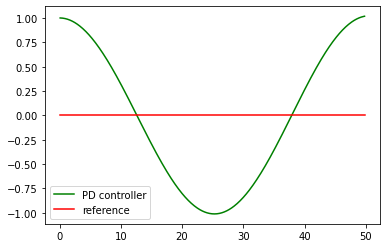

In [4]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# Note that tau is called "param" in the function
# below.
#
# Your code should print output that looks like
# the output shown in the video. That is, at each step:
# print myrobot, steering
#
# Only modify code at the bottom!
# ------------
 
from math import *
import random
import numpy as np
import matplotlib.pyplot  as plt
%matplotlib inline


# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, must be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
    
# ------------------------------------------------------------------------
#
# run - does a single control run

x_trajectory=[]
y_trajectory=[]
def run(param):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    speed = 0.1 # motion distance is equal to speed (we assume time = 1)
    N = 500
    #
    # Add Code Here
    for i in range(N):
        steering= -param*myrobot.y
        myrobot=myrobot.move(steering,speed)
        #print (i,myrobot, steering)
        x_trajectory.append(myrobot.x)
        y_trajectory.append(myrobot.y)
    # 

run(0.3) # call function with parameter tau of 0.1 and print results


n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()


800


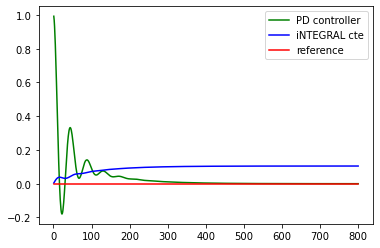

In [41]:
# -----------
# User Instructions
#
# Implement a PD controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE
# where differential crosstrack error (diff_CTE)
# is given by CTE(t) - CTE(t-1)
#
# Your code should print output that looks like
# the output shown in the video.
#
# Only modify code at the bottom!
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # make a new copy
        # res = Robot()
        # res.length = self.length
        # res.steering_noise = self.steering_noise
        # res.distance_noise = self.distance_noise
        # res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

# previous P controller
def run_p(robot, tau, n=500, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    for i in range(n):
        cte = robot.y
        steer = -tau * cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
    
def run(robot, tau_p, tau_d, n=500, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    cte = robot.y
    for i in range(n):
        diff_cte = robot.y-cte
        cte = robot.y
        steering=-tau_p*cte -tau_d*diff_cte
        robot.move(steering,speed)
        #print (robot, steering)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    # TODO: your code here
    return x_trajectory, y_trajectory

def run_PID(robot, tau_p, tau_d, tau_i, n=800, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    int_trag=[]
    cte = robot.y
    integral_cte = 0
    for i in range(n):
        diff_cte = robot.y-cte
        cte = robot.y
        integral_cte += cte
        steering=-tau_p*cte -tau_d*diff_cte - tau_i*integral_cte
        robot.move(steering,speed)
        #print (robot, steering)
        x_trajectory.append(robot.x)
        int_trag.append(tau_i*integral_cte)
        y_trajectory.append(robot.y)
    # TODO: your code here
    return x_trajectory, y_trajectory, int_trag
    
robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(6.0/180.0*pi)

#x_trajectory, y_trajectory = run_p(robot, 0.3)

#x_trajectory, y_trajectory = run(robot, 0.4, 1.6, n=400)
x_trajectory, y_trajectory,integral_cte  = run_PID(robot, 0.4, 1.6,0.004)

n = len(x_trajectory)
print(n)

plt.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
plt.plot(x_trajectory, integral_cte, 'b', label='iNTEGRAL cte')

plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()





In [ ]:
0.1047 = 0.4*y

# Twiddle Algorithm

Iteration 0, best error = 8315.955485215645
Iteration 1, best error = 0.0434970807256939
Iteration 2, best error = 0.03065437362443958
Iteration 3, best error = 0.007677320020068962
Iteration 4, best error = 0.003220167427116315
Iteration 5, best error = 0.0016645945527960435
Iteration 6, best error = 0.0009761080831682494
Iteration 7, best error = 0.0006163432367765914
Iteration 8, best error = 0.00041102748054356214
Iteration 9, best error = 0.0001987737410103838
Iteration 10, best error = 1.176902590931792e-06
Iteration 11, best error = 7.050884269315375e-07
Iteration 12, best error = 1.379736668887161e-12
Iteration 13, best error = 1.379736668887161e-12
Iteration 14, best error = 1.379736668887161e-12
Iteration 15, best error = 1.0756081254419683e-12
Iteration 16, best error = 1.0756081254419683e-12
Iteration 17, best error = 1.0756081254419683e-12
Iteration 18, best error = 8.12857772854578e-13
Iteration 19, best error = 8.12857772854578e-13
Iteration 20, best error = 8.1285777285

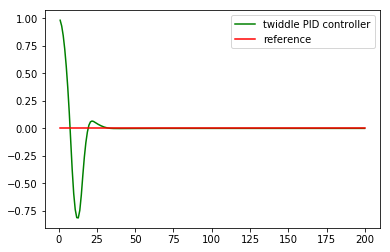

In [33]:
# NOTE: We use params instead of tau_p, tau_d, tau_i



def make_robot():
    """
    Resets the robot back to the initial position and drift.
    You'll want to call this after you call `run`.
    """
    robot = Robot()
    robot.set(0, 1, 0)
    robot.set_steering_drift(10 / 180 * np.pi)
    return robot


def run_twiddle(robot, params, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    err = 0
    # TODO: your code here
    prev_cte = robot.y
    int_cte = 0
    for i in range(2 * n):
        cte = robot.y
        diff_cte = (cte - prev_cte) / speed
        int_cte += cte
        prev_cte = cte
        steer = -params[0] * cte - params[1] * diff_cte - params[2] * int_cte
        robot.move(steer, speed)
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
        if i >= n:
            err += cte ** 2
    return x_trajectory, y_trajectory, err / n


# Make this tolerance bigger if you are timing out!
def twiddle(tol=0.2): 
    # TODO: Add code here
    # Don't forget to call `make_robot` before you call `run`!
    p = [0, 0, 0]
    dp = [1, 1, 1]
    robot = make_robot()
    x_trajectory, y_trajectory, best_err = run_twiddle(robot, p)

    it = 0
    while sum(dp) > tol:
        print("Iteration {}, best error = {}".format(it, best_err))
    
        for i in range(len(p)):
            p[i] += dp[i]
            robot = make_robot()
            x_trajectory, y_trajectory, err = run_twiddle(robot, p)

            if err < best_err:
                best_err = err
                dp[i] *= 1.1
            else:
                p[i] -= 2 * dp[i]
                robot = make_robot()
                x_trajectory, y_trajectory, err = run_twiddle(robot, p)

                if err < best_err:
                    best_err = err
                    dp[i] *= 1.1
                else:
                    p[i] += dp[i]
                    dp[i] *= 0.9
        it += 1
    return p


params = twiddle()
print(params)
robot = make_robot()
x_trajectory, y_trajectory, err = run_twiddle(robot, params)
n = len(x_trajectory)

plt.plot(x_trajectory, y_trajectory, 'g', label='twiddle PID controller')
plt.plot(x_trajectory, np.zeros(n), 'r', label='reference')
plt.legend()


In [ ]:
import msvcrt
c = msvcrt.getch()
print ('you entered', c)

In [ ]:
applicant = input("Enter the applicant's name: ")
interviewer = input("Enter the interviewer's name: ")
time = input("Enter the appointment time: ")
print(interviewer, "will interview", applicant, "at", time)